# Esercitazione 5 - Kernel

Oggi abbandoniamo il mondo dei classificatori e regressori lineari e iniziamo ad usare i Kernel.

Un kernel è definito a partire da una funzione di distanza (come ad esempio le norme p, esponenziali, etc)

Oggi vedremo come, al variare dei kernel, cambia la superficie di decisione imparata dall'algoritmo predittivo che sfrutta i kernel.

<a target="_blank" href="https://colab.research.google.com/github/zangobot/BusinessAnalytics_TeachingMaterial/blob/main/Esercitazione%205%20-%20Kernel.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [9]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('dati/penguins_size.csv').dropna()

Per capire come funzionano le distanze calcolate dai kernel, usiamo scikit-learn per caclolare i seguenti kernel:

* **Kernel Lineare**: $k(x_i, x_j) = x_i^tx_j$
* **Kernel Gaussiano (o Radial Base Function)**: $k(x_i, x_j) = e^{-\gamma \parallel x_i - x_j \parallel_2^2}$
* **Kernel Polinomiale**: $k(x_i, x_j) = (\gamma x_i^t x_j)^d$

Creiamo dei plot di queste funzioni per capire come si comportano.

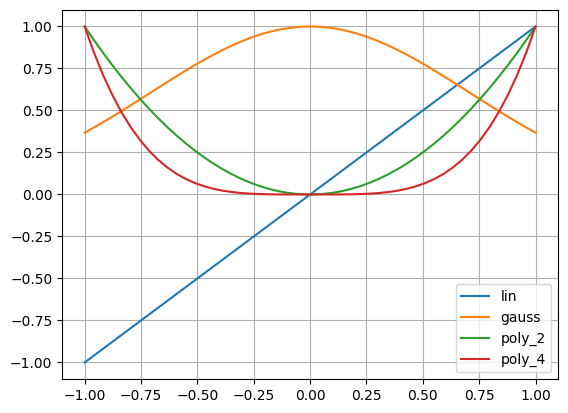

In [19]:
import numpy as np


def linear(x):
    return x


def gaussian(x, gamma):
    return np.exp(-gamma * pow(x, 2))


def polynomial(x, degree, gamma):
    return pow(gamma * x, degree)


t = np.linspace(-1, 1)
y_lin = linear(t)
y_gauss = gaussian(t, gamma=1)
y_poly2 = polynomial(t, degree=2, gamma=1)
y_poly4 = polynomial(t, degree=4, gamma=1)

plt.plot(t, y_lin, label='lin')
plt.plot(t, y_gauss, label='gauss')
plt.plot(t, y_poly2, label='poly_2')
plt.plot(t, y_poly4, label='poly_4')
plt.grid(True)
plt.legend()

Da questa visualizzazione possiamo notare che i kernel non lineari si comportano molto diversamente allontanandosi / avvicinandosi a 0.
Intuitivamente, cosa possiamo quindi aspettarci mentre usiamo queste funzioni?

Ora applichiamo i kernel ai dati dei pinguini:

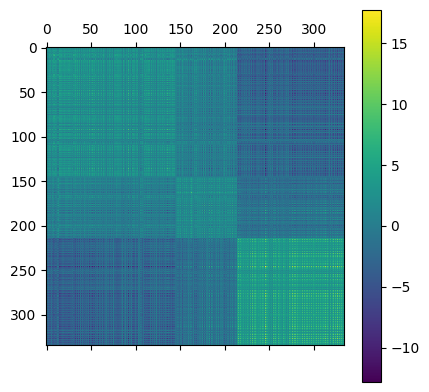

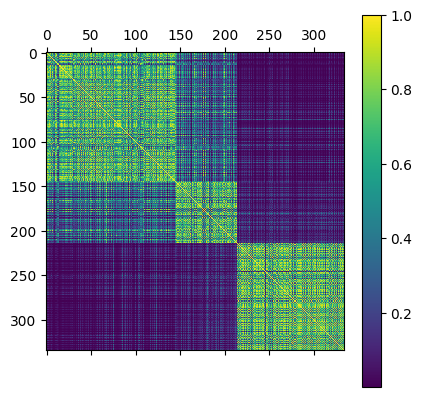

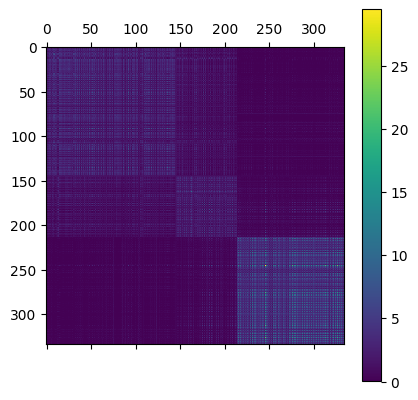

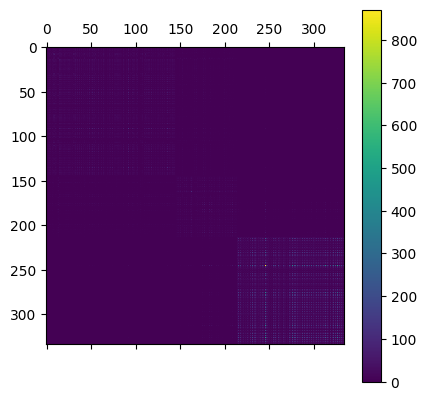

In [20]:
from sklearn.metrics.pairwise import linear_kernel, polynomial_kernel, rbf_kernel

K_1 = linear_kernel(X)
K_2 = rbf_kernel(X)
K_3 = polynomial_kernel(X, degree=2)
K_4 = polynomial_kernel(X, degree=4)

plt.matshow(K_1)
plt.colorbar()
plt.matshow(K_2)
plt.colorbar()
plt.matshow(K_3)
plt.colorbar()
plt.matshow(K_4)
plt.colorbar()


Come potete osservare, quasi tutti i kernel isolano tre aree all'interno dei dati.
Cosa pensate possa significare?

## Effetto dei parametri del kernel sulla regressione

Iniziamo ad inserire i kernel dentro gli algoritmi predittivi.
Per capirne meglio l'utilizzo, creiamo una funzione da far imparare ad un regressore (Ridge).

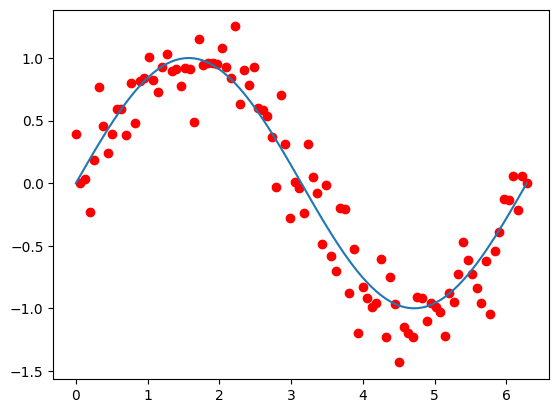

In [53]:
t = np.linspace(0, 2 * np.pi, 100, np.pi / 100).reshape(-1, 1)
noise = np.random.randn(*t.shape) * 0.2
real = np.sin(t)
x = np.sin(t) + noise

plt.plot(t, real)
plt.scatter(t, x, c='r')

/Users/zangobot/opt/miniconda3/envs/tai/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


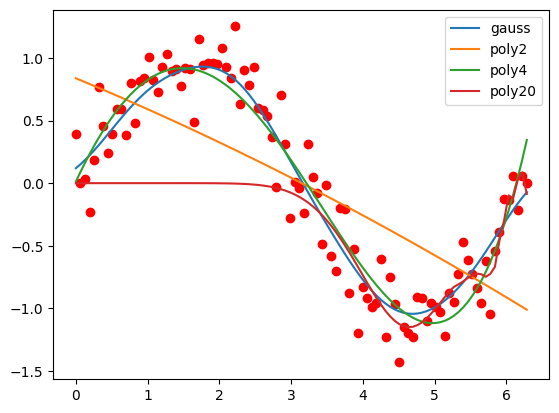

In [57]:
from sklearn.kernel_ridge import KernelRidge

krdige_gauss = KernelRidge(kernel='rbf', gamma=1).fit(t, x)
krdige_poly2 = KernelRidge(kernel='poly', gamma=1, degree=2).fit(t, x)
krdige_poly4 = KernelRidge(kernel='poly', gamma=1, degree=4).fit(t, x)
krdige_poly20 = KernelRidge(kernel='poly', gamma=1, degree=20).fit(t, x)

plt.scatter(t, x, c='r')
plt.plot(t, krdige_gauss.predict(t), label='gauss')
plt.plot(t, krdige_poly2.predict(t), label='poly2')
plt.plot(t, krdige_poly4.predict(t), label='poly4')
plt.plot(t, krdige_poly20.predict(t), label='poly20')
plt.legend()


Che cosa possiamo notare? Che cosa succede al variare dei parametri del kernel polinomiale?

# Support Vector Machines

Vediamo ora l'effetto dei kernel all'interno di un algoritmo predittivo di classificazione.
Prendiamo Support Vector Machine (SVM), un algoritmo predittivo che calcola la retta che meglio divide i dati, massimizzando il margine:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/1920px-SVM_margin.png" width=800>

L'effetto dei kernel dentro SVM è il seguente:

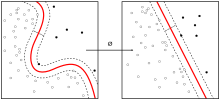

In [58]:
from IPython.core.display import SVG

display(SVG(url='https://upload.wikimedia.org/wikipedia/commons/f/fe/Kernel_Machine.svg'))

Creiamo ora diverse SVM con diversi kernel usando i dati dei pinguini, cercando di capire che effetto hanno sulla classificazione.

In [60]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, encoder, **params):
    Z = encoder.transform(clf.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_decision_region(clf, X, Y, title, x_label, y_label, classes, color='rgb'):
    colors = cycle(color)
    encoder = LabelEncoder().fit(Y)
    X0, X1 = X[x_label], X[y_label]
    xx, yy = make_meshgrid(X0, X1)
    fig, ax = plt.subplots()
    plot_contours(ax, clf, xx, yy, encoder, cmap=plt.cm.coolwarm, alpha=0.8)
    for c in classes:
        X[Y == c].plot.scatter(x_label, y_label, ax=ax, color=next(colors), label=c)
    ax.set_title(title)

/Users/zangobot/opt/miniconda3/envs/tai/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/zangobot/opt/miniconda3/envs/tai/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/zangobot/opt/miniconda3/envs/tai/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/zangobot/opt/miniconda3/envs/tai/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


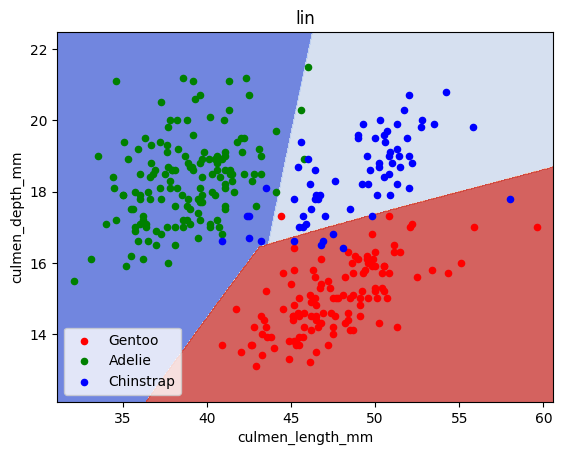

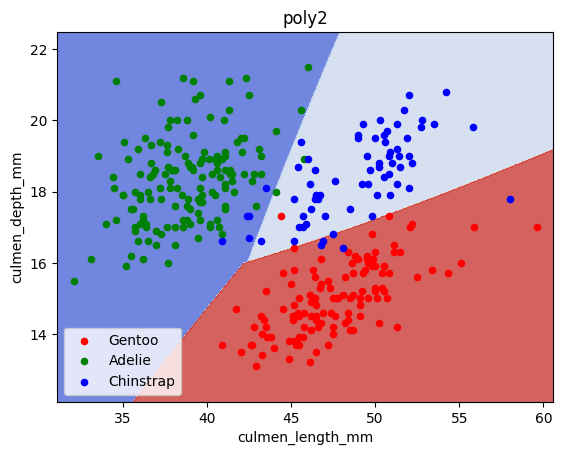

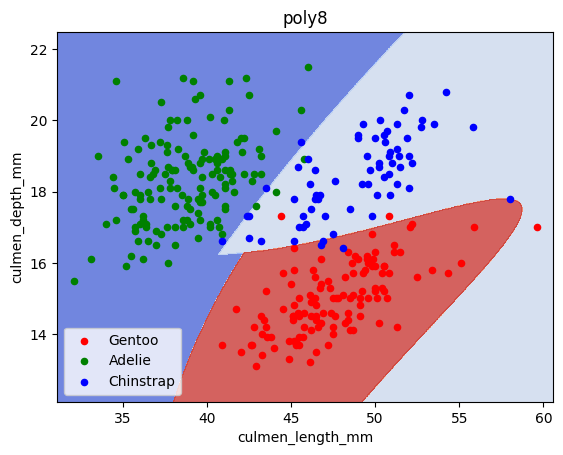

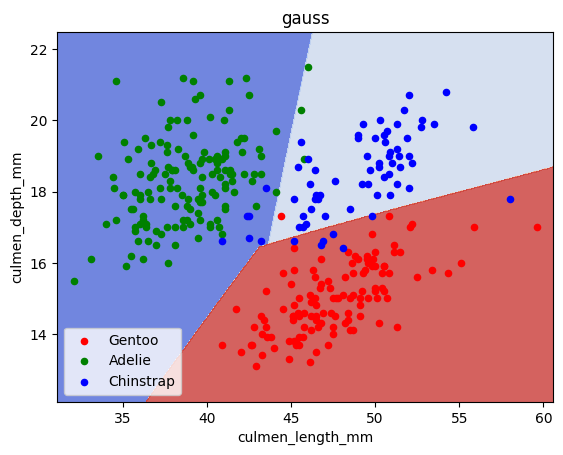

In [63]:
from sklearn.svm import SVC

lin_svm = SVC()
poly2_svm = SVC(kernel='poly', degree=2)
poly8_svm = SVC(kernel='poly', degree=8)
gauss_svm = SVC(kernel='rbf')

clfs = [(lin_svm, 'lin'), (poly2_svm, 'poly2'), (poly8_svm, 'poly8'), (gauss_svm, 'gauss')]

X, Y = data[['culmen_length_mm', 'culmen_depth_mm']], data['species']

for c, name in clfs:
    c.fit(X, Y)
    plot_decision_region(c, X, Y, name, 'culmen_length_mm', 'culmen_depth_mm', classes=["Gentoo", "Adelie", "Chinstrap"])